In [17]:
import os
from openai import OpenAI
import time
import json
from bigbench.api import json_task
from tqdm import tqdm
import random

# Set up OpenAI client using environment variable for API key
client = OpenAI(
    api_key = 'LA-b66744d449e94d7db2496843d9044308604a57fc8a0b42019c2ddac89ef8052d',
    base_url="https://api.llama-api.com"
)

# Different scales of LLaMA model variants to evaluate
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]

# Function to evaluate a specific model on the BIG-bench dataset
def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        prompt = example['input']
        target = example['target']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

### Testing on simple_arithmetic

In [ ]:
# Load BIG-bench dataset - replace 'path/to/BIG-bench' with actual path to the JSON file
json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/simple_arithmetic_json/task.json'

if not os.path.exists(json_path):
    raise FileNotFoundError(f"The specified path does not exist: {json_path}")

with open(json_path, 'r') as f:
    bigbench_dataset = json.load(f)

# Function to evaluate a specific model on the BIG-bench dataset
def evaluate_model(model_name, dataset):
    print(f"Evaluating model: {model_name}")
    results = []

    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")

    for example in dataset['examples']:
        prompt = example['input']
        target = example['target']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response.choices[0])
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

# Evaluate each model variant and store results
all_results = {}
for model in model_variants:
    all_results[model] = evaluate_model(model, bigbench_dataset)

# # Print the results for analysis
# for model, results in all_results.items():
#     print(f"\nResults for {model}:")
#     for result in results:
#         print(f"Prompt: {result['prompt']}")
#         print(f"Generated: {result['generated_text']}")
#         print(f"Target: {result['target']}\n")

Evaluating model: llama3.2-90b-vision
Evaluating model: llama3.2-11b-vision
Evaluating model: llama3.2-3b
Evaluating model: llama3.2-1b
Evaluating model: mixtral-8x22b-instruct
Evaluating model: mixtral-8x7b-instruct
Evaluating model: mistral-7b-instruct


In [38]:
# Function to calculate accuracy of the model
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        # if result['prompt'] + " " + result['target'] in result['generated_text']:
        #     correct_count += 1
        # elif result['target'] == result['generated_text']:
        #     correct_count += 1
        if result['target'] in result['generated_text']:
            correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")


Accuracy for llama3.2-90b-vision: 100.00%
Accuracy for llama3.2-11b-vision: 100.00%
Accuracy for llama3.2-3b: 90.00%
Accuracy for llama3.2-1b: 90.00%
Accuracy for mixtral-8x22b-instruct: 100.00%
Accuracy for mixtral-8x7b-instruct: 100.00%
Accuracy for mistral-7b-instruct: 96.67%


### Testing on modified_arithmetic

In [45]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
]

# Function to evaluate a specific model on the BIG-bench dataset
def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        prompt = example['input']
        target = example['target']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        # if result['prompt'] + " " + result['target'] in result['generated_text']:
        #     correct_count += 1
        # elif result['target'] == result['generated_text']:
        #     correct_count += 1
        if result['target'] in result['generated_text']:
            correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

In [ ]:
base_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/modified_arithmetic'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    for task_name in os.listdir(base_path):
        task_path = os.path.join(base_path, task_name)
        task_json_path = os.path.join(task_path, 'task.json')

        if os.path.isdir(task_path) and os.path.exists(task_json_path):
            with open(task_json_path, 'r') as f:
                bigbench_dataset = json.load(f)
            # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
            # Evaluate each model variant and store results
            all_results[model] += evaluate_model(model, bigbench_dataset)

In [ ]:
# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 39.00%
Accuracy for llama3.2-11b-vision: 30.33%
Accuracy for llama3.2-3b: 28.00%
Accuracy for llama3.2-1b: 28.67%


In [ ]:
model_variants = [
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
    'llama3.1-8b',
    'llama3.1-70b',
    'llama3.1-405b',
    # 'Llama-3.1-8B-Instruct',
    # 'Llama-3.1-70B-Instruct',
    # 'Llama-3.1-405B-Instruct',
]
# all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    for task_name in os.listdir(base_path):
        task_path = os.path.join(base_path, task_name)
        task_json_path = os.path.join(task_path, 'task.json')

        if os.path.isdir(task_path) and os.path.exists(task_json_path):
            with open(task_json_path, 'r') as f:
                bigbench_dataset = json.load(f)
            # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
            # Evaluate each model variant and store results
            all_results[model] += evaluate_model(model, bigbench_dataset)

# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

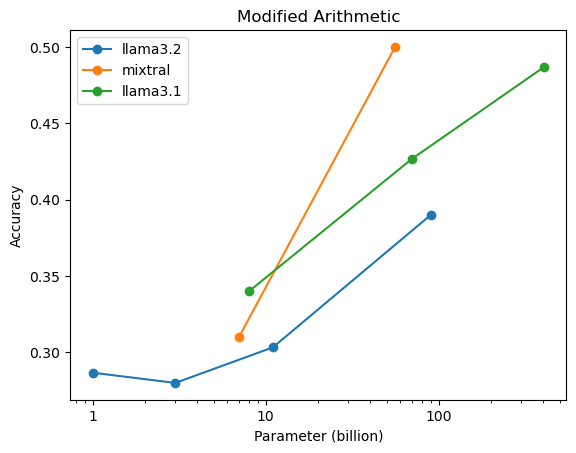

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.2867, 0.28, 0.3033, 0.39]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.2')
x = np.array([7, 7*8]) 
y = [0.31, 0.50]
plt.plot(x, y, marker='o', linestyle='-', label='mixtral')
x = np.array([8, 70, 405]) 
y = [0.34, 0.4267, 0.4867]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.1')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("Modified Arithmetic")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### Testing on international_phonetic_alphabet_transliterate

In [48]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'llama3.1-8b',
    'llama3.1-70b',
    'llama3.1-405b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/international_phonetic_alphabet_transliterate/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.isdir(task_path) and os.path.exists(task_json_path):
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset, 200)

Evaluating model: llama3.2-90b-vision


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [06:50<00:00,  2.05s/it]


Evaluating model: llama3.2-11b-vision


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [04:22<00:00,  1.31s/it]


Evaluating model: llama3.2-3b


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


Evaluating model: llama3.2-1b


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [03:52<00:00,  1.16s/it]


Evaluating model: llama3.1-8b


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [05:15<00:00,  1.58s/it]


Evaluating model: llama3.1-70b


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [05:40<00:00,  1.70s/it]


Evaluating model: llama3.1-405b


international_phonetic_alphabet_transliterate:  96%|█████████▋| 193/200 [10:39<00:18,  2.62s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


international_phonetic_alphabet_transliterate:  98%|█████████▊| 195/200 [11:03<00:34,  6.88s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


international_phonetic_alphabet_transliterate:  98%|█████████▊| 197/200 [11:21<00:21,  7.30s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


international_phonetic_alphabet_transliterate:  99%|█████████▉| 198/200 [11:45<00:24, 12.30s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


international_phonetic_alphabet_transliterate: 100%|█████████▉| 199/200 [12:24<00:20, 20.27s/it]

Failed to get response after 3 attempts for prompt: IPA: ðə neɪm əv ðə ˈaɪləndz ər beɪst ɔn ðɛr təˈpɑgrəfi.
English:
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [13:03<00:00,  3.92s/it]


Failed to get response after 3 attempts for prompt: English: The rock is harder than most types of rock.
IPA:
Evaluating model: mixtral-8x22b-instruct


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [07:56<00:00,  2.38s/it]


Evaluating model: mixtral-8x7b-instruct


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Evaluating model: mistral-7b-instruct


international_phonetic_alphabet_transliterate:  19%|█▉        | 38/200 [01:01<04:23,  1.63s/it]

Error occurred for model mistral-7b-instruct: Error code: 400 - {'detail': 'Failed to process your request. Please try again later. If you are processing a function, try using a larger model (70b) for better function formatting.'}


international_phonetic_alphabet_transliterate: 100%|██████████| 200/200 [05:27<00:00,  1.64s/it]


In [ ]:
# Print the results for analysis
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [49]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(results):
    total_bleu = 0
    total_count = len(results)

    for result in results:
        reference = [result['target'].split()]
        candidate = result['generated_text'].split()
        bleu_score = sentence_bleu(reference, candidate)
        total_bleu += bleu_score

    average_bleu = (total_bleu / total_count) * 100 if total_count > 0 else 0
    return average_bleu

# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_bleu(results)
    print(f"BLEU for {model}: {accuracy:.2f}%")

BLEU for llama3.2-90b-vision: 42.50%
BLEU for llama3.2-11b-vision: 14.95%
BLEU for llama3.2-3b: 5.37%
BLEU for llama3.2-1b: 0.40%
BLEU for llama3.1-8b: 9.65%
BLEU for llama3.1-70b: 40.45%
BLEU for llama3.1-405b: 40.97%
BLEU for mixtral-8x22b-instruct: 28.09%
BLEU for mixtral-8x7b-instruct: 8.34%
BLEU for mistral-7b-instruct: 7.05%


/Users/shawna_song/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/shawna_song/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/shawna_song/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

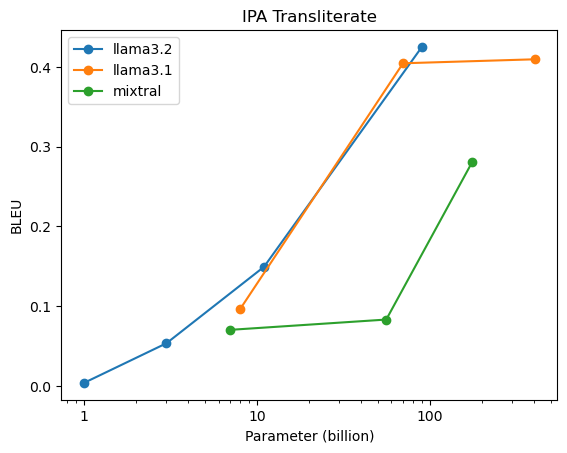

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.0040, 0.0537, 0.1495, 0.425]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.2')
x = np.array([8, 70, 405]) 
y = [0.0965, 0.4045, 0.4095]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.1')
x = np.array([7, 8*7, 8*22]) 
y = [0.0705, 0.0834, 0.2809]
plt.plot(x, y, marker='o', linestyle='-', label='mixtral')

plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("IPA Transliterate")
plt.xlabel("Parameter (billion)")
plt.ylabel("BLEU")
plt.legend()
plt.show()

### Testing on word_unscrambling

In [53]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'llama3.1-8b',
    'llama3.1-70b',
    'llama3.1-405b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/word_unscrambling/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.isdir(task_path) and os.path.exists(task_json_path):
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset, 150)

Evaluating model: llama3.2-90b-vision


word_unscrambling: 100%|██████████| 150/150 [04:29<00:00,  1.79s/it]


Evaluating model: llama3.2-11b-vision


word_unscrambling: 100%|██████████| 150/150 [03:31<00:00,  1.41s/it]


Evaluating model: llama3.2-3b


word_unscrambling: 100%|██████████| 150/150 [03:23<00:00,  1.36s/it]


Evaluating model: llama3.2-1b


word_unscrambling: 100%|██████████| 150/150 [03:04<00:00,  1.23s/it]


Evaluating model: llama3.1-8b


word_unscrambling: 100%|██████████| 150/150 [03:19<00:00,  1.33s/it]


Evaluating model: llama3.1-70b


word_unscrambling: 100%|██████████| 150/150 [03:44<00:00,  1.50s/it]


Evaluating model: llama3.1-405b


word_unscrambling:  39%|███▉      | 59/150 [03:01<05:14,  3.46s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  44%|████▍     | 66/150 [03:46<06:20,  4.52s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  62%|██████▏   | 93/150 [06:42<04:56,  5.20s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  69%|██████▉   | 104/150 [07:37<03:38,  4.76s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  70%|███████   | 105/150 [08:16<11:15, 15.02s/it]

Failed to get response after 3 attempts for prompt: The word atx is a scrambled version of the English word 
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  71%|███████   | 106/150 [08:54<16:06, 21.97s/it]

Failed to get response after 3 attempts for prompt: The word pcielsa is a scrambled version of the English word 
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  71%|███████▏  | 107/150 [09:33<19:29, 27.21s/it]

Failed to get response after 3 attempts for prompt: The word leceonvi is a scrambled version of the English word 
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  72%|███████▏  | 108/150 [10:12<21:28, 30.69s/it]

Failed to get response after 3 attempts for prompt: The word eamsn is a scrambled version of the English word 
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling:  73%|███████▎  | 109/150 [10:49<22:14, 32.54s/it]

Failed to get response after 3 attempts for prompt: The word iprnisgrsu is a scrambled version of the English word 


word_unscrambling:  77%|███████▋  | 116/150 [11:20<03:25,  6.04s/it]

Error occurred for model llama3.1-405b: 'ChatCompletion' object is not subscriptable


word_unscrambling: 100%|██████████| 150/150 [14:11<00:00,  5.68s/it]


Evaluating model: mixtral-8x22b-instruct


word_unscrambling: 100%|██████████| 150/150 [05:27<00:00,  2.19s/it]


Evaluating model: mixtral-8x7b-instruct


word_unscrambling: 100%|██████████| 150/150 [04:02<00:00,  1.61s/it]


Evaluating model: mistral-7b-instruct


word_unscrambling: 100%|██████████| 150/150 [04:01<00:00,  1.61s/it]


In [ ]:
# Print the results for analysis
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [54]:
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        # if result['prompt'] + " " + result['target'] in result['generated_text']:
        #     correct_count += 1
        # elif result['target'] == result['generated_text']:
        #     correct_count += 1
        # print(result)
        if isinstance(result['target'] , list):
            for target_word in result['target']:
                if target_word in result['generated_text']: 
                    correct_count += 1
                    break
        else:
            if result['target'] in result['generated_text']:
                correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 40.00%
Accuracy for llama3.2-11b-vision: 18.67%
Accuracy for llama3.2-3b: 10.67%
Accuracy for llama3.2-1b: 12.67%
Accuracy for llama3.1-8b: 24.00%
Accuracy for llama3.1-70b: 46.00%
Accuracy for llama3.1-405b: 49.66%
Accuracy for mixtral-8x22b-instruct: 24.00%
Accuracy for mixtral-8x7b-instruct: 12.67%
Accuracy for mistral-7b-instruct: 12.00%


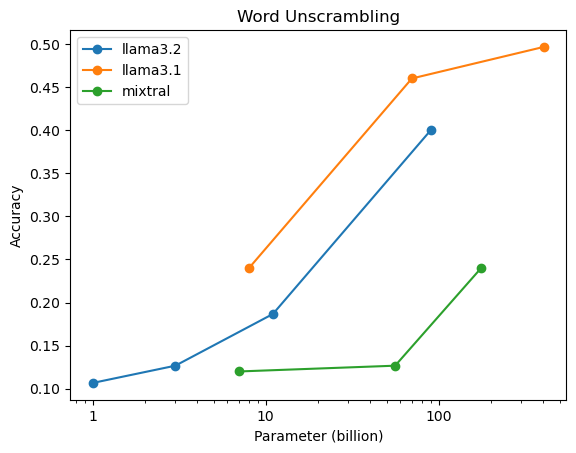

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.1067, 0.1267, 0.1867, 0.40]
plt.plot(x, y, marker='o', linestyle='-', label="llama3.2")
x = np.array([8, 70, 405]) 
y = [0.24, 0.46, 0.4966]
plt.plot(x, y, marker='o', linestyle='-', label="llama3.1")
x = np.array([7, 8*7, 8*22]) 
y = [0.12, 0.1267, 0.24]
plt.plot(x, y, marker='o', linestyle='-', label="mixtral")
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("Word Unscrambling")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Testing on parsinlu_qa

In [59]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'llama3.1-8b',
    'llama3.1-70b',
    'llama3.1-405b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]

def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        choices = list(example['target_scores'].keys())
        prompt = example['input'] + " choose from: " + ','.join(choices)
        target = example['target_scores']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/parsinlu_qa/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.exists(task_json_path):
        # print(f"Evaluating model: {model}")
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset, 100)

Evaluating model: llama3.2-90b-vision


parsinlu_qa: 100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


Evaluating model: llama3.2-11b-vision


parsinlu_qa: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


Evaluating model: llama3.2-3b


parsinlu_qa: 100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Evaluating model: llama3.2-1b


parsinlu_qa: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


Evaluating model: llama3.1-8b


parsinlu_qa: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


Evaluating model: llama3.1-70b


parsinlu_qa: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Evaluating model: llama3.1-405b


parsinlu_qa: 100%|██████████| 100/100 [05:07<00:00,  3.07s/it]


Evaluating model: mixtral-8x22b-instruct


parsinlu_qa:  70%|███████   | 70/100 [03:05<01:19,  2.64s/it]

Error occurred for model mixtral-8x22b-instruct: Error code: 400 - {'detail': 'Failed to process your request. Please try again later. If you are processing a function, try using a larger model (70b) for better function formatting.'}


parsinlu_qa: 100%|██████████| 100/100 [04:32<00:00,  2.72s/it]


Evaluating model: mixtral-8x7b-instruct


parsinlu_qa: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Evaluating model: mistral-7b-instruct


parsinlu_qa: 100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


In [ ]:
# Print the results for analysis
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [60]:
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        for choice in result['target'].keys():
            if result['target'][choice] == 1:
                if str(choice) in result['generated_text']:
                    correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 39.00%
Accuracy for llama3.2-11b-vision: 40.00%
Accuracy for llama3.2-3b: 25.00%
Accuracy for llama3.2-1b: 19.00%
Accuracy for llama3.1-8b: 34.00%
Accuracy for llama3.1-70b: 42.00%
Accuracy for llama3.1-405b: 52.00%
Accuracy for mixtral-8x22b-instruct: 10.00%
Accuracy for mixtral-8x7b-instruct: 21.00%
Accuracy for mistral-7b-instruct: 9.00%


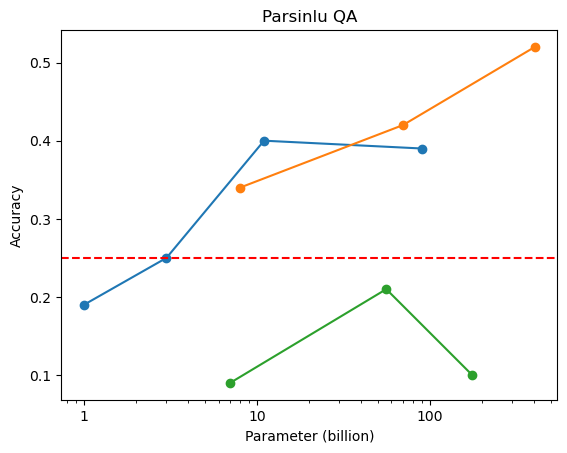

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.19, 0.25, 0.40, 0.39]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.2')
x = np.array([8, 70, 405]) 
y = [0.34, 0.42, 0.52]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.1')
x = np.array([7, 8*7, 8*22]) 
y = [0.09, 0.21, 0.10]
plt.plot(x, y, marker='o', linestyle='-', label='mixtral')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.axhline(y=0.25, color='red', linestyle='--', label='Baseline: 0.25')
plt.title("Parsinlu QA")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
model_variants = [
    'Qwen1.5-0.5B-Chat',
    'Qwen1.5-1.8B-Chat',
    'Qwen1.5-14B-Chat',
    'Qwen1.5-32B-Chat',
    'Qwen1.5-110B-Chat',
]

### Testing on Truthful_qa

In [64]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'llama3.1-8b',
    'llama3.1-70b',
    'llama3.1-405b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]
def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        choices = list(example['target_scores'].keys())
        prompt = example['input'] + "\nchoose from: \n" + '\n'.join(choices)
        target = example['target_scores']
        # print(prompt)
        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/truthful_qa/task_mc.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.exists(task_json_path):
        # print(f"Evaluating model: {model}")
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        all_results[model] += evaluate_model(model, bigbench_dataset, 100)

Evaluating model: llama3.2-90b-vision


truthful_qa: 100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


Evaluating model: llama3.2-11b-vision


truthful_qa: 100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Evaluating model: llama3.2-3b


truthful_qa: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


Evaluating model: llama3.2-1b


truthful_qa: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Evaluating model: llama3.1-8b


truthful_qa: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


Evaluating model: llama3.1-70b


truthful_qa: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Evaluating model: llama3.1-405b


truthful_qa: 100%|██████████| 100/100 [05:22<00:00,  3.22s/it]


Evaluating model: mixtral-8x22b-instruct


truthful_qa: 100%|██████████| 100/100 [04:27<00:00,  2.68s/it]


Evaluating model: mixtral-8x7b-instruct


truthful_qa: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


Evaluating model: mistral-7b-instruct


truthful_qa: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


In [ ]:
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [65]:
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        for choice in result['target'].keys():
            if result['target'][choice] == 1:
                if str(choice) in result['generated_text']:
                    # print(str(choice))
                    correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 68.00%
Accuracy for llama3.2-11b-vision: 63.00%
Accuracy for llama3.2-3b: 41.00%
Accuracy for llama3.2-1b: 20.00%
Accuracy for llama3.1-8b: 58.00%
Accuracy for llama3.1-70b: 79.00%
Accuracy for llama3.1-405b: 74.00%
Accuracy for mixtral-8x22b-instruct: 40.00%
Accuracy for mixtral-8x7b-instruct: 60.00%
Accuracy for mistral-7b-instruct: 24.00%


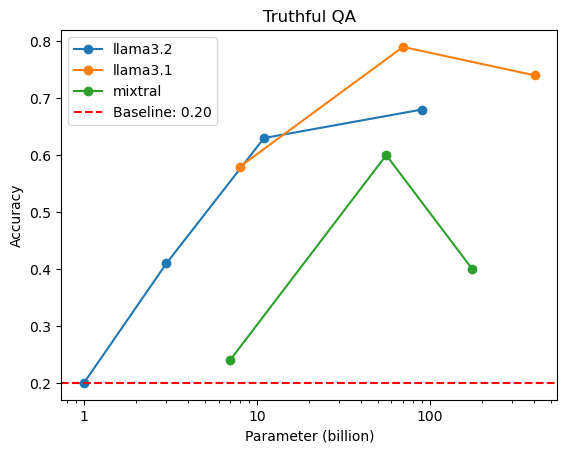

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.20, 0.41, 0.63, 0.68]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.2')
x = np.array([8, 70, 405]) 
y = [0.58, 0.79, 0.74]
plt.plot(x, y, marker='o', linestyle='-', label='llama3.1')
x = np.array([7, 8*7, 8*22]) 
y = [0.24, 0.60, 0.40]
plt.plot(x, y, marker='o', linestyle='-', label='mixtral')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
# plt.axhline(y=0.20, color='red', linestyle='--', label='Baseline: 0.20')
plt.title("Truthful QA")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()